# Final Tutorial: Pokemon Data Analysis
## Who's That Pokemon??
#### Ayyub Ahmed: 114183064
#### Prath Kotgire:  

### Introduction

Do you know what Pokemon are? If not, what have you been doing all your life? Get educated!! Anyway this is an analysis of Pokemon related data.
We want to see if it's possible to identify a Pokemon's type based on other information about said Pokemon, such as base stats, body size, etc.



### Required Libraries

You must have the following libraries installed: Pandas, Numpy, Matplotlib, Seaborn, Scipy, Sklearn


In [22]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold 
from bs4 import BeautifulSoup as bs
# from scipy import stats, integrate

## 1. Getting Started
First we must collect our data from the source: https://pokemondb.net/pokedex/all. Then we tidy it up so it is easier to analyze.

In [3]:
#### NO NEED TO RUN!!!!!! ALREADY SAVED DATA IN .CSV FILE!!

# # scrape the data from the website
# r = requests.get('https://pokemondb.net/pokedex/all')
# soup = bs(r.text, 'html.parser')
# prettysoup = soup.prettify()
# read = pd.read_html(prettysoup)

# # create the dataframe, fixing column names
# df= pd.DataFrame(read[0])
# df.columns = ["NatID","Name","Type","Total","HP","Attack","Defense","SpAtk","SpDef","Speed"]

# # separate 'Type' into 'Type1' and 'Type2' and readjust
# types = pd.DataFrame(df.Type.str.split('  ',1).tolist(), columns = ['Type1','Type2'])
# df = pd.concat([df,types],axis = 1)
# df.drop(['Type'], axis=1)
# df = df[["NatID","Name","Type1","Type2","Total","HP","Attack","Defense","SpAtk","SpDef","Speed"]]
# df['Type2'].fillna(value='None', inplace = True)

# # remove duplicates (other forms of the same pokemon i.e. Mega Evolutions)
# filter = df['Name'].str.contains("Mega ")
# df = df[~filter]
# df = df.drop_duplicates(subset='NatID', keep="first")

# # reset the index after dropping rows
# df = df.reset_index(drop=True)

# # fixes names of specific cases
# idx = 0
# for name in df["Name"]:
#     if "  " in name:
#         df.loc[idx, "Name"] = name.split(" ",1)[0]
#     idx+=1

# # add a column to classify Pokemon by Generation
# idx = 0
# df['Generation'] = 0
# for x in df["NatID"]:   
#     if df['NatID'][idx] <= 151:
#         df.loc[idx,'Generation'] = 1
#     elif df['NatID'][idx] > 151 and df['NatID'][idx] <= 251:
#         df.loc[idx,'Generation'] = 2
#     elif df['NatID'][idx] > 251 and df['NatID'][idx] <= 386:
#         df.loc[idx,'Generation'] = 3
#     elif df['NatID'][idx] > 386 and df['NatID'][idx] <= 493:
#         df.loc[idx,'Generation'] = 4
#     elif df['NatID'][idx] > 493 and df['NatID'][idx] <= 649:
#         df.loc[idx,'Generation'] = 5
#     elif df['NatID'][idx] > 649 and df['NatID'][idx] <= 721:
#         df.loc[idx,'Generation'] = 6
#     else:
#         df.loc[idx,'Generation'] = 7
#     idx+=1
    
# df.head()

Our dataframe is missing some useful information. We need to get this missing data by scraping the individual webpage for each Pokemon. To do so, we wrote a function that collects only useful info and tidies it up.

In [4]:
# a function to retrieve additional info for each Pokemon from their individual webpages
def getPokeData (name):

    # Modify string for special cases
    if (name == "Nidoran♀"):
        name = "Nidoran-f"
    elif (name == "Nidoran♂"):
        name = "Nidoran-m"
    elif (name == "Farfetch'd"):
        name = "Farfetchd"
    elif (name == "Mr. Mime"):
        name = "Mr-Mime"
    elif (name == "Mime Jr."):
        name = "Mime-Jr"
    elif (name == "Flabébé"):
        name = "Flabebe"
    elif (name == "Type: Null"):
        name = "Type-Null"
    elif (" " in name):
        name = name.replace(" ", "-")
         
    # collect data for each Pokemon from the database
    r = requests.get('https://pokemondb.net/pokedex/' + name)
    soup = bs(r.text, 'html.parser')
    prettysoup = soup.prettify()
    read = pd.read_html(prettysoup)

    # Get the different types of data
    df1 = pd.DataFrame(read[0])
    df2 = pd.DataFrame(read[1])
    df3 = pd.DataFrame(read[2])

    # Transpose the data so it is attributes are in columns
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    # Fix header for each table
    new_header = df1.iloc[0] 
    df1 = df1[1:] 
    df1.columns = new_header 

    new_header = df2.iloc[0] 
    df2 = df2[1:] 
    df2.columns = new_header 

    new_header = df3.iloc[0] 
    df3 = df3[1:] 
    df3.columns = new_header 

    # Drop Irrelevant columns for table 1
    if "Japanese" in df1.columns:
        df1 = df1.drop(["Japanese"], axis=1)
    df1 = df1.drop(["Type", "Abilities", "Species", "Local №"], axis=1)
    df1.columns = ["NatID", "Height (m)", "Weight (kg)"]

    df2 = df2.drop(["EV yield", "Base EXP", "Growth Rate", "Base Happiness"], axis=1)
    df2.columns = ["Catch Rate"]

    df3 = df3.drop(["Egg cycles"], axis=1)

    # Concat the 3 dataframes
    df= pd.concat([df1, df2, df3], axis=1)

    # Get rid of extraneous information
    df["Height (m)"].iloc[0] = df["Height (m)"].iloc[0].split("(")[1].split("m")[0]
    df["Weight (kg)"].iloc[0] = df["Weight (kg)"].iloc[0].split("(")[1].split(" ")[0]
    df["Catch Rate"].iloc[0] = df["Catch Rate"].iloc[0].split(" ")[0]


    # Split Egg Groups into 2 separate colulmns
    if "Genderless" in df['Gender'].iloc[0]:
        df['Gender'].iloc[0] = "0.0% male, 0.0% female"

    df['Male (%)'] = df.Gender.str.split(",",1).tolist()[0][0]
    df['Male (%)'] = df['Male (%)'].str.split("%",1).tolist()[0][0]
    df['Female (%)'] = df.Gender.str.split(",",1).tolist()[0][1]
    df['Female (%)'] = df['Female (%)'].str.split("%",1).tolist()[0][0]
    df.drop(['Gender'], axis=1, inplace=True)

    # Split Egg Groups into 2 separate colulmns
    if "," not in df['Egg Groups'].iloc[0]:
        df['Egg Groups'].iloc[0] += ", N/A"

    df['Egg Group 1'] = df['Egg Groups'].str.split(",",1).tolist()[0][0]
    df['Egg Group 2'] = df['Egg Groups'].str.split(",",1).tolist()[0][1]
    df.drop(['Egg Groups'], axis=1, inplace=True)

    # Change typing from string to appropriate type for each column
    df['NatID'] = df['NatID'].astype(int) 
    df['Height (m)'] = df['Height (m)'].astype(float) 
    df['Weight (kg)'] = df['Weight (kg)'].astype(float) 
    df['Catch Rate'] = df['Catch Rate'].astype(int) 
    df['Male (%)'] = df['Male (%)'].astype(float) 
    df['Female (%)'] = df['Female (%)'].astype(float) 
    
    return df

We now have a function that collects more info for each Pokemon and we need to call it then add that info to our original dataframe. However, this will take quite some time so we will save the data in a '.csv' file to ease access to our data later.

In [5]:
#### NO NEED TO RUN! ALREADY SAVED DATA IN .CSV FILE!!!!!
# # make a dataframe for the additional columns needed
# add_info = pd.DataFrame()

# # scrape the additional data for each Pokemon
# for name in df['Name']:
#     add_info = add_info.append(getPokeData(name))
        
# # merge the new columns of data with the original dataframe
# df= pd.merge(df,add_info, on=['NatID'], how="left")

# # store the dataframe in a '.csv' for ease of access later, rather than scrape data from the website each time
# df.to_csv("PokeData_Full.csv")

Now that the data is collected and stored in a '.csv' file, we can easily access it to continue our analysis.

In [6]:
# load the previously stored data
df = pd.read_csv("PokeData_Full.csv",  encoding='latin-1')
df.drop("Unnamed: 0", axis = 1, inplace=True)
df

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Height (m),Weight (kg),Catch Rate,Male (%),Female (%),Egg Group 1,Egg Group 2
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0.71,6.9,45,87.5,12.5,Grass,Monster
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0.99,13.0,45,87.5,12.5,Grass,Monster
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,2.01,100.0,45,87.5,12.5,Grass,Monster
3,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,0.61,8.5,45,87.5,12.5,Dragon,Monster
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,1.09,19.0,45,87.5,12.5,Dragon,Monster
5,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,1.70,90.5,45,87.5,12.5,Dragon,Monster
6,7,Squirtle,Water,None,314,44,48,65,50,64,43,1,0.51,9.0,45,87.5,12.5,Monster,Water 1
7,8,Wartortle,Water,None,405,59,63,80,65,80,58,1,0.99,22.5,45,87.5,12.5,Monster,Water 1
8,9,Blastoise,Water,None,530,79,83,100,85,105,78,1,1.60,85.5,45,87.5,12.5,Monster,Water 1
9,10,Caterpie,Bug,None,195,45,30,35,20,20,45,1,0.30,2.9,255,50.0,50.0,Bug,N/A


## 2. Exploratory Data Analysis
Let's try to find some patterns in data. First we'll separate the data into groups based on Type (regardless of whether its Type 1 or Type 2). Then we'll try to see trends across these groups.

In [34]:
# makes a dataframe with type2 swapped type1
df2 = df.copy();
df2 = df2.rename(columns={'Type1': 'Type2','Type2': 'Type1'})
df2 = df2[["NatID", "Name", "Type1", "Type2", "Total", "HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", \
           "Generation", "Height (m)", "Weight (kg)", "Catch Rate", "Male (%)", "Female (%)", "Egg Group 1", "Egg Group 2"]]

# fixes None issues and merges the two dataframes into a new one
df3 = df.copy();
for index, row in df2.iterrows():
    if row["Type1"] != "None":
        df3 = df3.append(row)
        
# drops useless columns (Type2) and renames "Type1" to "Type"
df3.drop("Type2", 1,inplace=True)
df3 = df3.rename(columns={'Type1': 'Type'})

Let's start our analysis by examining the distribution of the Pokemons' total base stats for each type. To do this, we will plot a boxplot overlapped with a stripplot. You can see where the darker points of the stripplot are, showing where the higher concentration of Pokemon are.

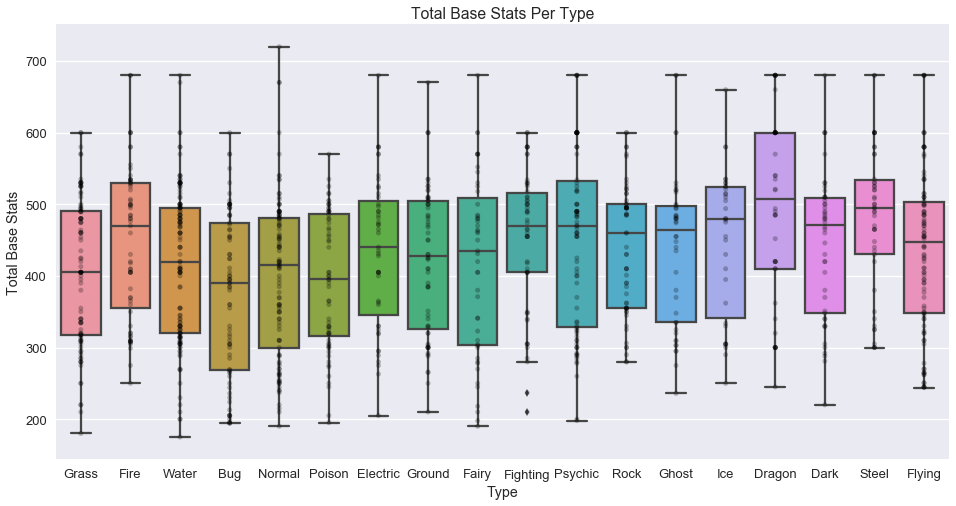

In [8]:
# Change the size of the plot to something more reasonable for viewing
sns.set(style="darkgrid", color_codes=False)
sns.set_context("talk", font_scale=1)
fig, ax = plt.subplots(figsize=(16,8))

# Plot the total base stats by type in a violin plot overlapped with a strip plot 
sns.boxplot(x="Type", y="Total", data=df3)
sns.stripplot(x="Type", y="Total", data=df3, color='k', alpha=.25)

plt.ylabel('Total Base Stats')
plt.title('Total Base Stats Per Type')
plt.show()

From this we can see that Dragon-type, Fighting-type, Steel-type Pokemon generally have high total base stats, with Dragon-type being the highest. The lower quartile for these types are all above 400, with the median of Dragon-type being above 500. In comparison, some of the weaker Pokemon types would be Grass-types, Bug-types, and Poison-type, with the median being about 400. Looking at the Dragon-type, you can there are few points within the box itself but are more concentrated at the ends of the quartile, meaning that even among the Dragon-type Pokemon, there is a split between the weak and the strong. Compare this to either the Flying-type or Normal-type which have a more clear and even distribution of points across the box.

### Catch Rate

Now let's look at the Catch Rate of each Pokemon based on their type. The Catch Rate represents the difficulty a player will face when attempting to capture a wild Pokemon (a wild Pokemon is one found naturally in the game without a current owner). Usually, if a Pokemon is rare (Legendary even), then they will be harder to catch, thus the Pokemon will have a lower catch rate. So naturally if a Pokemon is quite common, it will have a higher catch rate.

Let's look at another boxplot, this one representing Catch Rate per Type.

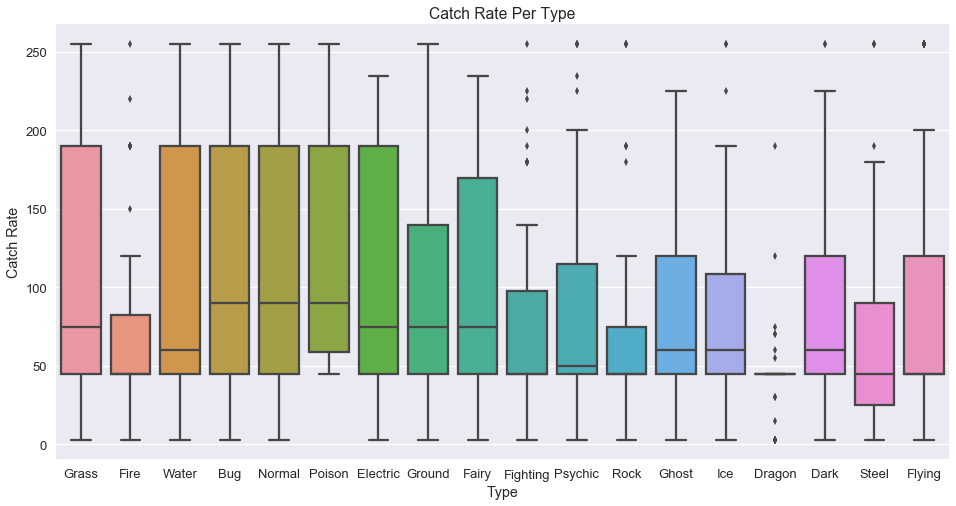

In [9]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))
sns.set_context("talk", font_scale=1)

# Plot a boxplot of Catch Rate by Type 
sns.boxplot(x="Type", y="Catch Rate", data=df3)

plt.title('Catch Rate Per Type')
plt.show()

As we can see, undoubtedly, the lowest catch rate of any Pokemon type would be the Dragon-type with the upper, middle and lower quartile all being about the same, other than a few outliers. We can conclude that Dragon-type Pokemon are the hardest wild Pokemon for a player to catch and may be harder to find. We can also see that Fire-type and Rock-type have no visible middle quartile and the box is small, so the range of the catch rate is small, and low, so the Pokemon of these types are relatively harder to catch. Note that the Steel-type Pokemon has a lower-quartile that is below all the others, while its middle matches with the others' lower-quartile. This means that other than Dragon-type Pokemon, Steel-type Pokemon have the lowest catch rate and are hard to catch. In comparison to these lower catch rates, we can see Bug-type, Normal-type, and Poison-type have the highest median and therefore, are the easiest to catch and may be more common.


It seems like the Pokemon types that had high Total Stats might also be Pokemon that have low Catch Rate. Let's plot them against each other and see if there are any noticable trends

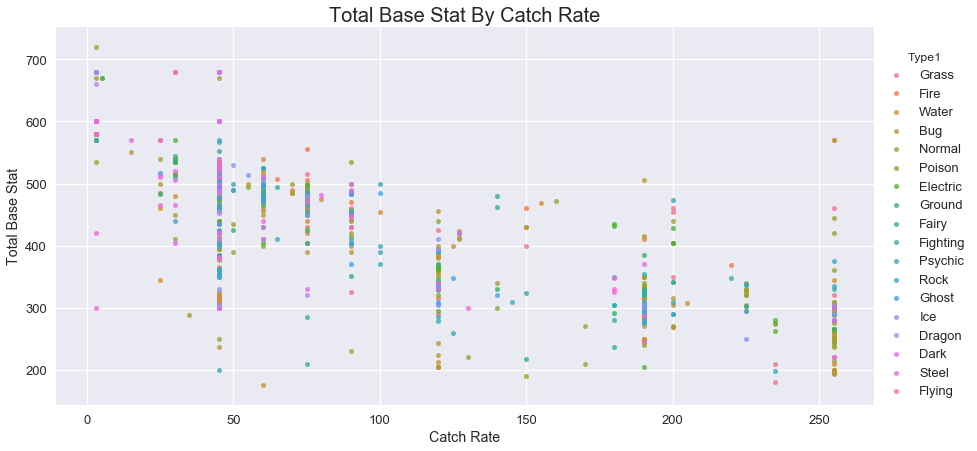

In [60]:
# Plot a lineplot of total base stat over catch rate
sns.lmplot(x='Catch Rate',y='Total', data=df, fit_reg=False, hue='Type1',\
           size= 6.25, aspect=2, scatter_kws={"s": 25})
# label and show plot
plt.title('Total Base Stat By Catch Rate', fontsize=20)
plt.ylabel('Total Base Stat')
plt.show()

#### It is evident that there is a trend, but let's plot a regression line to see the trend even more clearly.

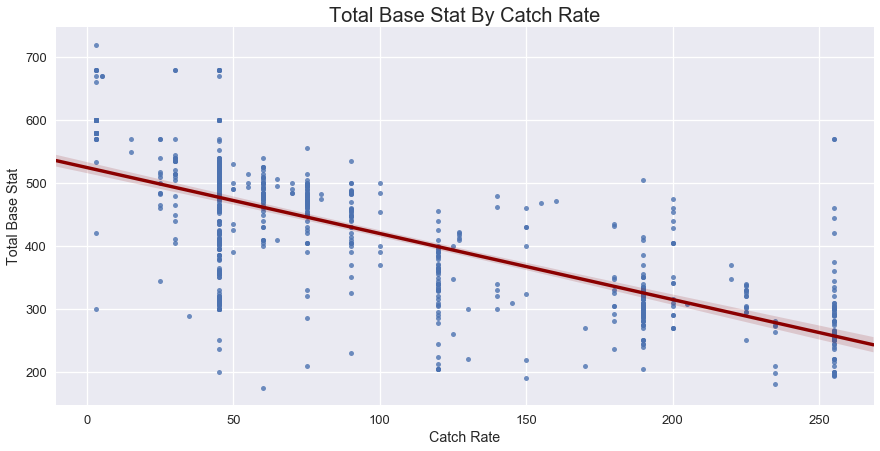

In [61]:
# using Seaborn,plot a 2-d polynomial regression on the scatter plot of total stats by catch rate with visual customizations
sns.lmplot(x='Catch Rate',y='Total', data=df,fit_reg=True, \
           size= 6.25, aspect=2, scatter_kws={"s": 25}, line_kws={'color':'darkred'}) # order=2,

# label and show plot
plt.title('Total Base Stat By Catch Rate', fontsize=20)
plt.ylabel('Total Base Stat')
plt.show()

Now that we have our polynomial regression line plotted, we can clearly see that there is a negative relationship between Pokemon's total base stats and their catch rate. This supports our assumption that a Pokemon's catch rate is dependant on their strength, meaning stronger Pokemon are harder to catch and weaker Pokemon are easier to catch.

Let's run an <a href="http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html">Ordinary Least Squares</a> Regression on our data, so we can further examine the details of the regression.

In [46]:
regress = sm.OLS(df['Total'],df['Catch Rate']).fit()
print(regress.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     598.2
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           4.11e-99
Time:                        19:55:11   Log-Likelihood:                -5787.6
No. Observations:                 802   AIC:                         1.158e+04
Df Residuals:                     801   BIC:                         1.158e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Catch Rate     2.2850      0.093     24.458      0.0

The OLS Regression summary shows us a variety of results in regard to the regression, but we only want to examine the relevant details. The relevant details are the 'R-squared' and 'coef' values. The coefficient value shows the effect that our independent variable (catch rate in this case) has on the dependent variable (total stats), where the smaller the coefficient results in a smaller effect. The R-squared value is the fraction of the variation in the dependent variable that is accounted for by the independent variable. Typically, the closer the R-squared value is to 1, the more accurate our regression line would be, but as we can see by the graph, there are many points of data that would contribute to skewing the R-squared value even though there is an evident negative relation between the total stats and catch rate.

In [62]:
# look at the Pokemon with the lowest catch rate order in descending order 
df[df['Catch Rate'] < 5].sort_values(['Catch Rate','Total'], ascending=False).head()

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Height (m),Weight (kg),Catch Rate,Male (%),Female (%),Egg Group 1,Egg Group 2
492,493,Arceus,Normal,None,720,120,120,120,120,120,120,4,3.20,320.0,3,0.0,0.0,Undiscovered,N/A
149,150,Mewtwo,Psychic,None,680,106,110,90,154,90,130,1,2.01,122.0,3,0.0,0.0,Undiscovered,N/A
248,249,Lugia,Psychic,Flying,680,106,90,130,90,154,110,2,5.21,216.0,3,0.0,0.0,Undiscovered,N/A
249,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,3.81,199.0,3,0.0,0.0,Undiscovered,N/A
383,384,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,7.01,206.5,3,0.0,0.0,Undiscovered,N/A


The Pokemon that have the lowest catch rate have the highest total stats in our data, and these specific Pokemon noted above are actually Legendary Pokemon. Legendary Pokemon are the rarest and usually the strongest, so they will have the highest stats and lowest catch rates. On the contrary, the Pokemon who have the highest catch rates tend to also have the lowest base stats, and may be more common, allowing a player to catch easy Pokemon early in the game.

### Generation Analysis

Let's see if there is any correlation between the Generation a Pokemon was added to the Pokemon universe and their stats. There may be a trend where Pokemon added to newer generations have higher stats in general than previous generations.
First let's look at the amount of Pokemon there are in each generation seperated by their type by using a combination of a violinplot and stripplot.

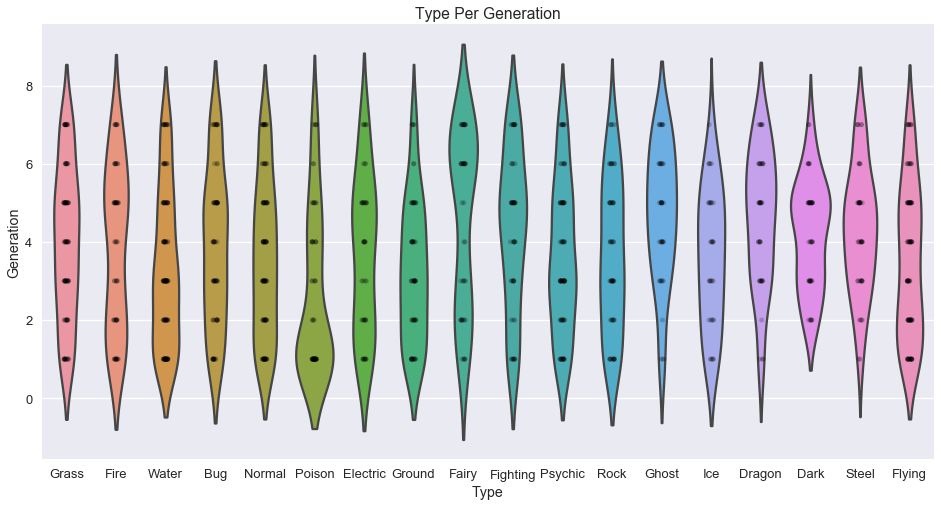

In [76]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))
sns.set_context("talk", font_scale=1)

# Plot each Pokemon on a plot of Total by Type1, colored by Generation 
sns.violinplot(x="Type", y="Generation", data=df3, inner=None)
sns.stripplot(x="Type", y="Generation", data=df3, color='k', alpha=.2, jitter=.05)

plt.title('Type Per Generation')
plt.show()

A violin plot shows where more points are concentrated by becoming wider in those areas. For example, looking at the violin for Poison-type Pokemon, we can see the majority of these Pokemon were introduced in the very first generation, since the violin seems to narrow as we go into newer generations. Compare this to Fairy-type, where the violin is widest around the sixth generation. This is further evidenced by the more opaque points in the wider regions and the more translucent points in the narrow regions. Additionally, Dark-type Pokemon have no values for the first generation, showing us that they were first introduced in the second generation, but most heavily in the fifth generation.

Now that we've taken a look at the generations with relation to types, let's see how they effect the total base stats of the Pokemon with respect to its type.

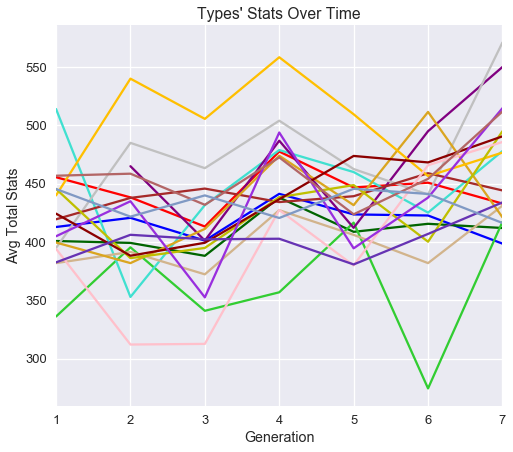

In [85]:
# filter the data grouping by types
type_normal = df[(df['Type1']=='Normal') | (df['Type2']=='Normal')]
type_fire = df[(df['Type1']=='Fire') | (df['Type2']=='Fire')]
type_water = df[(df['Type1']=='Water') | (df['Type2']=='Water')]
type_electric = df[(df['Type1']=='Electric') | (df['Type2']=='Electric')]
type_grass = df[(df['Type1']=='Grass') | (df['Type2']=='Grass')]
type_ice = df[(df['Type1']=='Ice') | (df['Type2']=='Ice')]
type_fighting = df[(df['Type1']=='Fighting') | (df['Type2']=='Fighting')]
type_poison = df[(df['Type1']=='Poison') | (df['Type2']=='Poison')]
type_ground = df[(df['Type1']=='Ground') | (df['Type2']=='Ground')]
type_flying = df[(df['Type1']=='Flying') | (df['Type2']=='Flying')]
type_psychic = df[(df['Type1']=='Psychic') | (df['Type2']=='Psychic')]
type_bug = df[(df['Type1']=='Bug') | (df['Type2']=='Bug')]
type_ghost =  df[(df['Type1']=='Ghost') | (df['Type2']=='Ghost')]
type_rock = df[(df['Type1']=='Rock') | (df['Type2']=='Rock')]
type_fairy = df[(df['Type1']=='Fairy') | (df['Type2']=='Fairy')]
type_steel = df[(df['Type1']=='Steel') | (df['Type2']=='Steel')]
type_dragon = df[(df['Type1']=='Dragon') | (df['Type2']=='Dragon')]
type_dark = df[(df['Type1']=='Dark') | (df['Type2']=='Dark')]

# group the types by generation and examine the total stats
fire_gen = type_fire.groupby('Generation')['Total'] 
water_gen = type_water.groupby('Generation')['Total'] 
grass_gen = type_grass.groupby('Generation')['Total']
normal_gen = type_normal.groupby('Generation')['Total']
bug_gen = type_bug.groupby('Generation')['Total']
ice_gen = type_ice.groupby('Generation')['Total']
dark_gen = type_dark.groupby('Generation')['Total']
steel_gen = type_steel.groupby('Generation')['Total']
rock_gen = type_rock.groupby('Generation')['Total']
ground_gen = type_ground.groupby('Generation')['Total']
dragon_gen = type_dragon.groupby('Generation')['Total']
electric_gen = type_electric.groupby('Generation')['Total']
fairy_gen = type_fairy.groupby('Generation')['Total']
fighting_gen = type_fighting.groupby('Generation')['Total']
ghost_gen = type_ghost.groupby('Generation')['Total']
poison_gen = type_poison.groupby('Generation')['Total']
psychic_gen = type_psychic.groupby('Generation')['Total']
flying_gen = type_flying.groupby('Generation')['Total']

# size of plot
plt.figure(figsize=(8,7))

# plot the average total stats over generation for each type (color-coded)
fire_gen.mean().plot(color='r')
water_gen.mean().plot(color='b')
grass_gen.mean().plot(color='darkgreen')
bug_gen.mean().plot(color='limegreen')
ice_gen.mean().plot(color='turquoise')
normal_gen.mean().plot(color='tan')
dark_gen.mean().plot(color='purple')
steel_gen.mean().plot(color='silver')
rock_gen.mean().plot(color='brown')
ground_gen.mean().plot(color='goldenrod')
dragon_gen.mean().plot(color=(1,.75,0))
electric_gen.mean().plot(color='y')
fairy_gen.mean().plot(color='pink')
fighting_gen.mean().plot(color='darkred')
ghost_gen.mean().plot(color=(.6,.18,.87))
poison_gen.mean().plot(color=(.4,.2,.7))
psychic_gen.mean().plot(color=(.7,.4,.4))
flying_gen.mean().plot(color=(.5,.6,.77))

# label and show plot
plt.ylabel("Avg Total Stats") 
plt.title("Types' Stats Over Time")
plt.show()

This graph displays the average total stats across the generations, with each line representing a different type. We can immediately infer from the graph that Bug-type Pokemon had the lowest average stats in generation 6, and that Dragon-type Pokemon were predominately the strongest Pokemon, having the highest stats for generations 2, 3, 4, and 5. We can see that Ice-type Pokemon, who had the highest stats for generation 1, dropped to the second lowest in generation 2 and never recovered their position as one of the strongest types. Also, in generation 7 we can see that Silver-type and Dark-type Pokemon have the highest total stats, with Silver-type setting a new record for having the highest average total stats across all the generations.

Let's visualize the same data in a more understandable manner, using bar graphs.

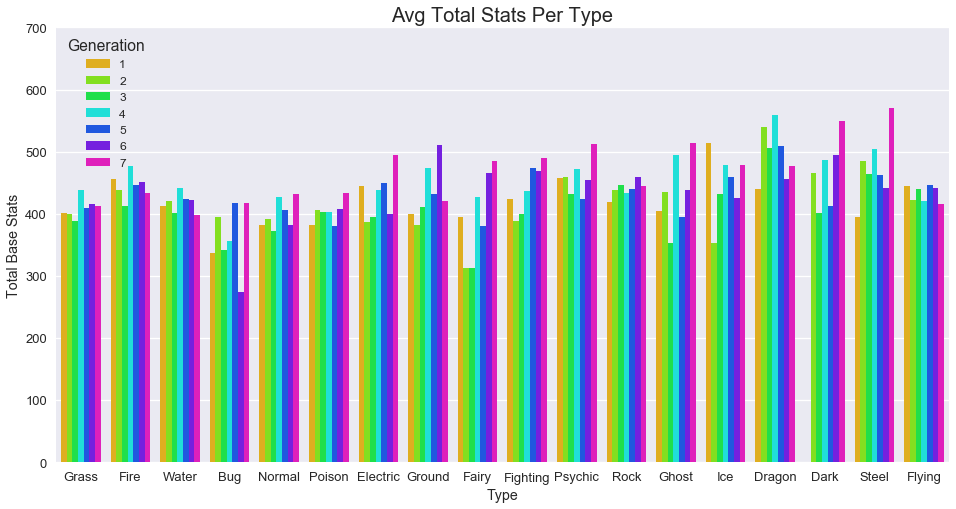

In [94]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))

# Plot each Pokemon on a plot of average total stats by type, colored by generation 
sns.barplot(x="Type", y="Total", data=df3, hue='Generation', errwidth=0, palette='hsv')

plt.ylabel('Total Base Stats')
plt.legend(title='Generation',loc=2,prop={'size':12})
plt.title('Avg Total Stats Per Type', fontsize=20)
plt.show()

There is a sizable amount of information to process here, with Dragon-type initially appearing to be the dominant type once again. It's clear that in generation 2 and 4, Dragon-type towers over the others, but not so much in generation 7. Generation 7 appears to feature stronger Pokemon of the Steel, Dark, and Psychic types. Fairy-type Pokemon also seemed to improve in generation 7 specifically when compared to generation 2 and 3, where they show the lowest stats on average. Again, we can see that in general that Bug-type Pokemon have lowest average total stats especially in generation 6.

However it's difficult to truly see the differences in the average stats for each type. Let's plot each of the average stats (HP, Attack, Defense, Special Attack, Special Defense, Speed) across the different types so we can see which types have the stats.

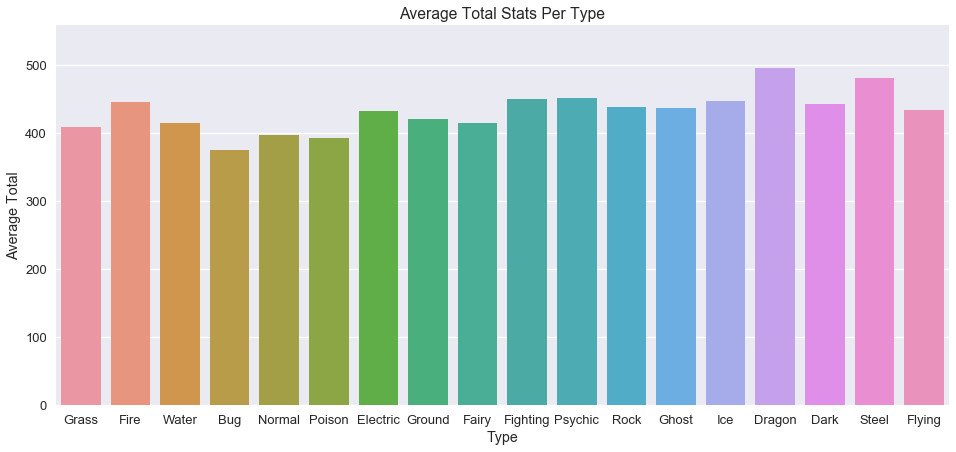

In [95]:
# TOTAL
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Total", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Total')
plt.title('Average Total Stats Per Type')
plt.show()

#### Here we can see without a doubt just as we've seen in all of our previous graphs, Dragon-type Pokemon have the highest total base stats followed by Steel-type Pokemon, and Bug-type Pokemon have the lowest.

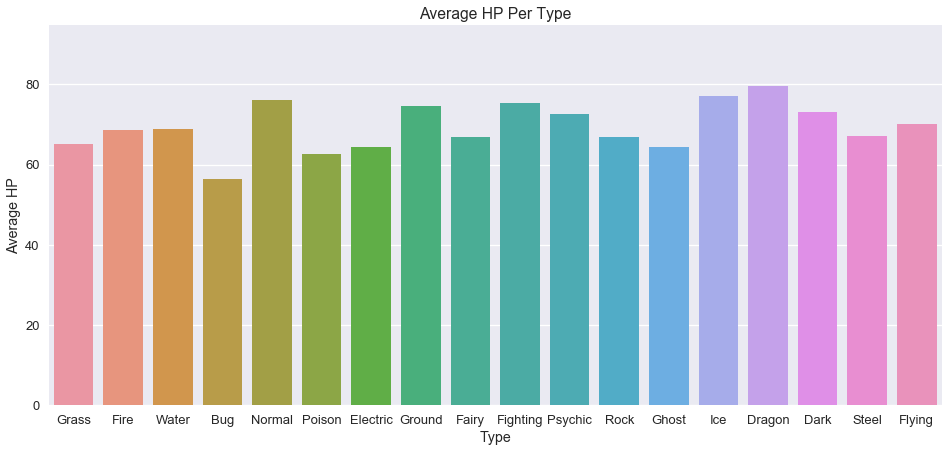

In [109]:
# HP
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="HP", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average HP')
plt.title('Average HP Per Type')
plt.show()

#### Here we can see Dragon-type Pokemon have the highest base HP followed by Ice-type Pokemon, and Bug-type Pokemon have the lowest again.

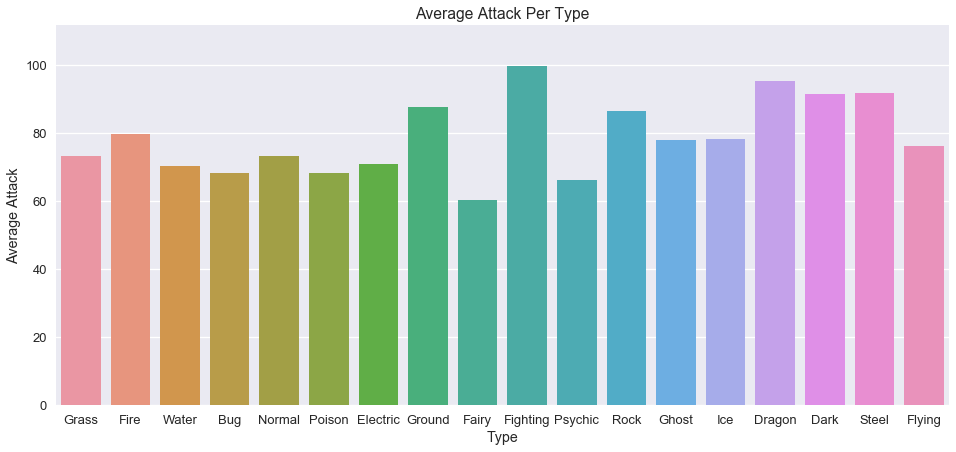

In [110]:
# Attack
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Attack", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Attack')
plt.title('Average Attack Per Type')
plt.show()

#### Here we can see that this time Fighting-type Pokemon have the highest base Attack but are followed by Dragon-type Pokemon, and this time Fairy-type Pokemon have the lowest.

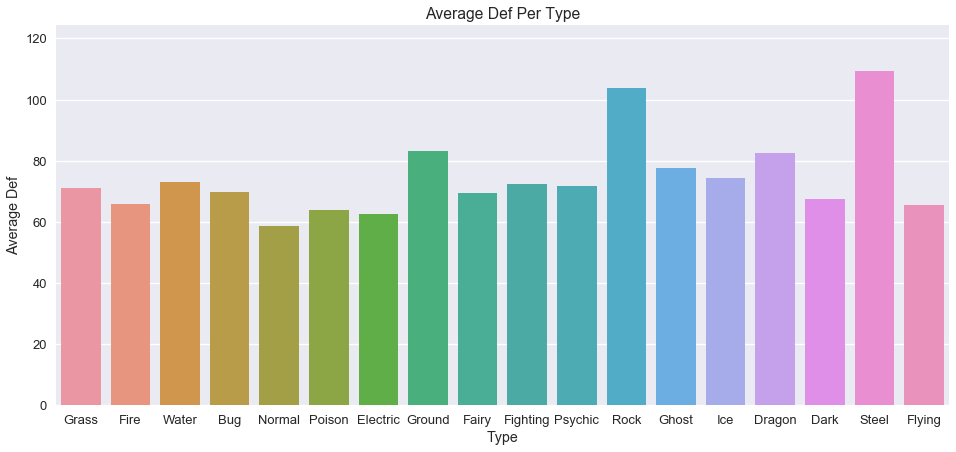

In [98]:
# Defense
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Defense", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Def')
plt.title('Average Def Per Type')
plt.show()


#### Here we can see Steel-type Pokemon have the highest base Defense followed by Rock-type Pokemon, and Normal-type Pokemon have the lowest.

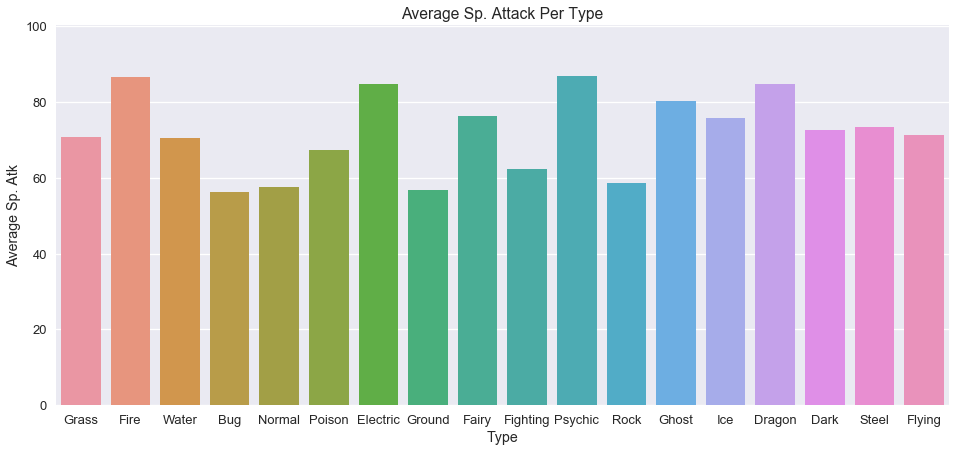

In [99]:
# Sp. Attack
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="SpAtk", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Sp. Atk')
plt.title('Average Sp. Attack Per Type')
plt.show()

#### Here we can see Psychic-type Pokemon have the highest base Special Attack, tied with Fire-type, followed by Electric-type Pokemon tied with Dragon-type Pokemon, and Bug-type Pokemon have the lowest again, tied with Ground-type.

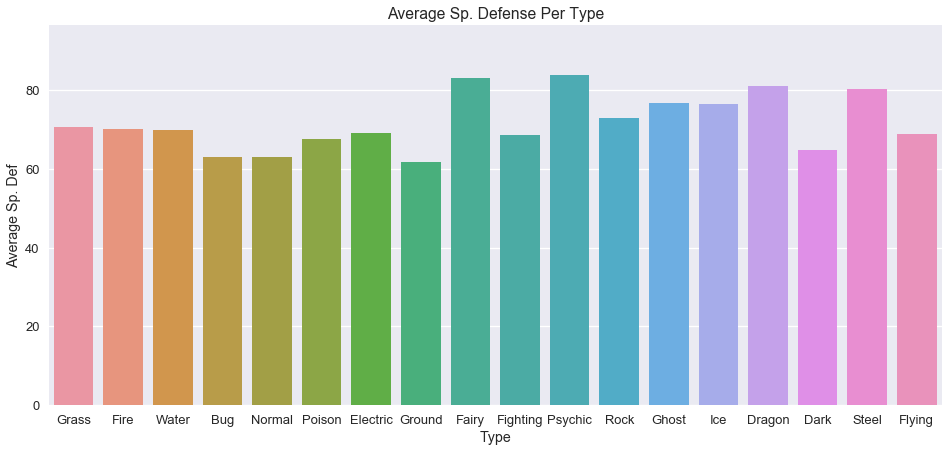

In [100]:
# Sp. Defense
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="SpDef", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Sp. Def')
plt.title('Average Sp. Defense Per Type')
plt.show()

#### Here we can see Psychic-type Pokemon have the highest base Special Defense, followed by Fairy-type Pokemon, and Ground-type Pokemon have the lowest.

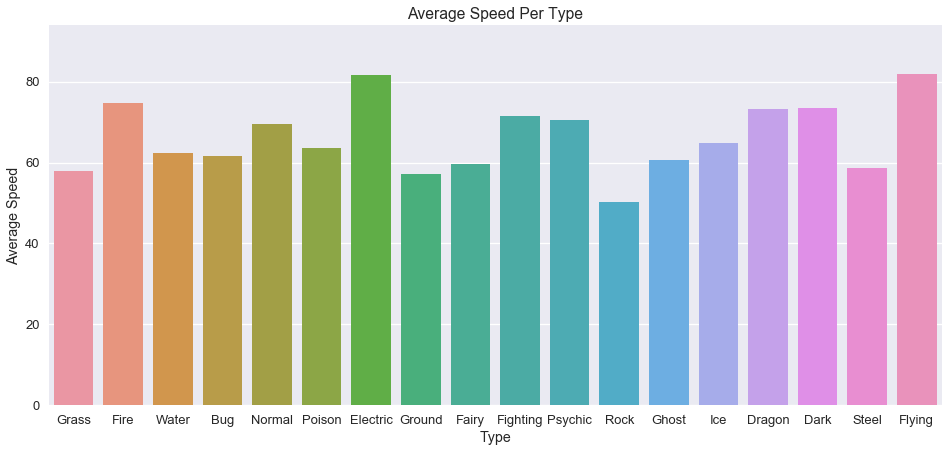

In [101]:
# Speed
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Speed", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Speed')
plt.title('Average Speed Per Type')
plt.show()

#### Here we can see Flying-type Pokemon have the highest base Speed, tied with Electric-type Pokemon, followed by Fire-type Pokemon, and Rock-type Pokemon have the lowest.

### Height and Weight
We've look at graphs of each stat for all the Pokemon types, but Pokemon also have physical attributes such as height and weight. Let's see if we can find anything noteworthy by graphing height and weight across types.

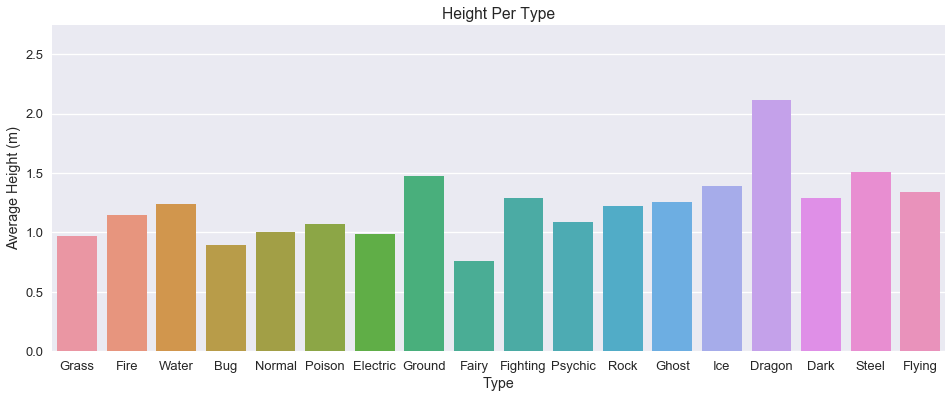

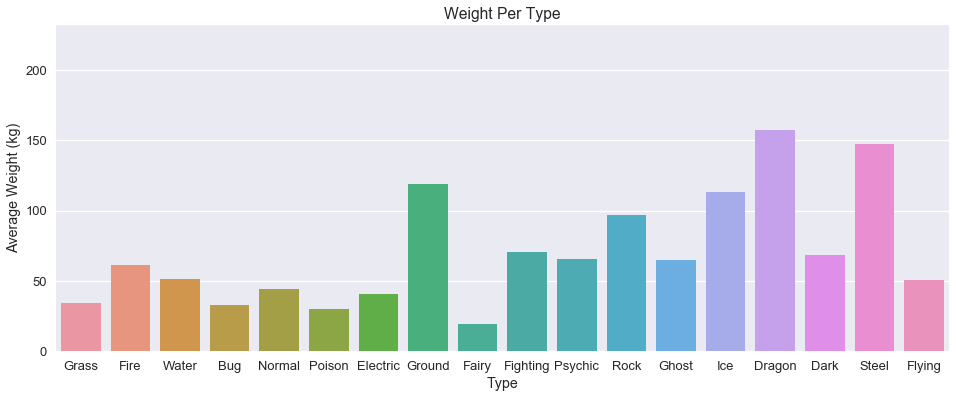

In [119]:
# Height
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))
sns.set_context("talk", font_scale=1)

# Plot Height by Type 
sns.barplot(x="Type", y="Height (m)", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Height (m)')
plt.title('Height Per Type')
plt.show()

# Weight
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))
sns.set_context("talk", font_scale=1)

# Plot Weight by Type 
sns.barplot(x="Type", y="Weight (kg)", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Weight (kg)')
plt.title('Weight Per Type')
plt.show()

The first graph shows the average height in meters of the Pokemon for each type, while the second graph shows the average weight in kilograms of the Pokemon for each type. We can see that the tallest Pokemon are starkly Dragon-type Pokemon, followed by Ground-type and Steel-type Pokemon. The smallest Pokemon are Fairy-type, and then Bug-type Pokemon. We can also that the heaviest Pokemon are Dragon-type, followed again by Steel-type and Ground-type Pokemon. The lightest Pokemon are once again Fairy-type, but followed by Poison-type Pokemon and Bug-type Pokemon not far behind.
We can conclude that the physcially biggest and heaviest Pokemon are primarily Dragon-type, and then Steel-type and Ground-type Pokemon, while the smallest and lightest Pokemon are Fairy-type, and then Bug-type Pokemon.

### Male and Female Genders
We've looked at the different base stats and now physical attributes. Now let's examine the Pokemon by their genders (Male and Female only...) for each type. Note that there are some Pokemon not accounted for in this part of the analysis because some Pokemon just don't have a gender, such as Legendary Pokemon.

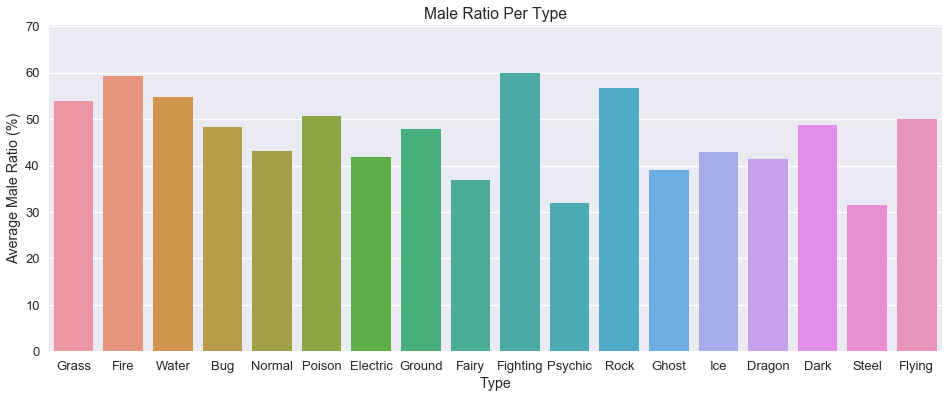

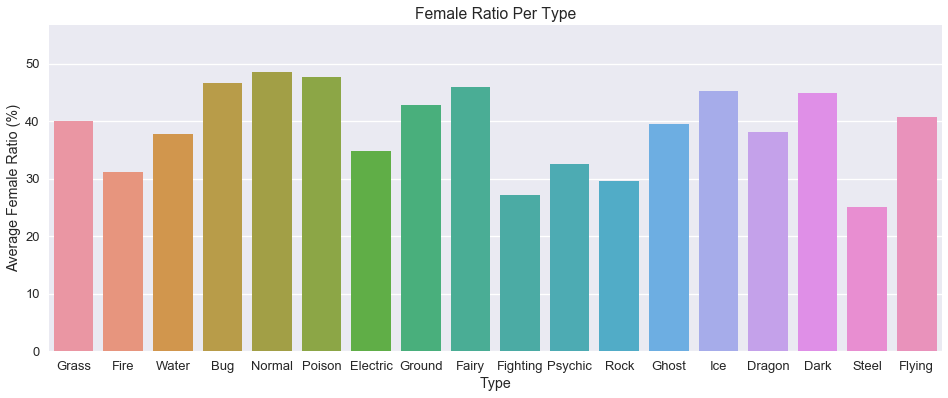

In [121]:
# Male Ratio
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))

# Plot Male Ratio by Type 
sns.barplot(x="Type", y="Male (%)", data=df3, errwidth=0)

plt.ylabel('Average Male Ratio (%)')
plt.title('Male Ratio Per Type')
plt.show()

# Female Ratio
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))

# Plot each Pokemon on a plot of Total by Type1, colored by Generation 
sns.barplot(x="Type", y="Female (%)", data=df3, errwidth=0)

plt.ylabel('Average Female Ratio (%)')
plt.title('Female Ratio Per Type')
plt.show()

The highest ratio of male Pokemon are Fighting-type, followed by Fire-type then Rock-type Pokemon, while the lowest is Steel-type and Psychic-type. The highest ratio of female Pokemon are Normal-type, followed by Poison-type then Bug-type tied with Fairy-type Pokemon. The lowest ratio of female Pokemon were also Steel-type, but then Fighting-type Pokemon.

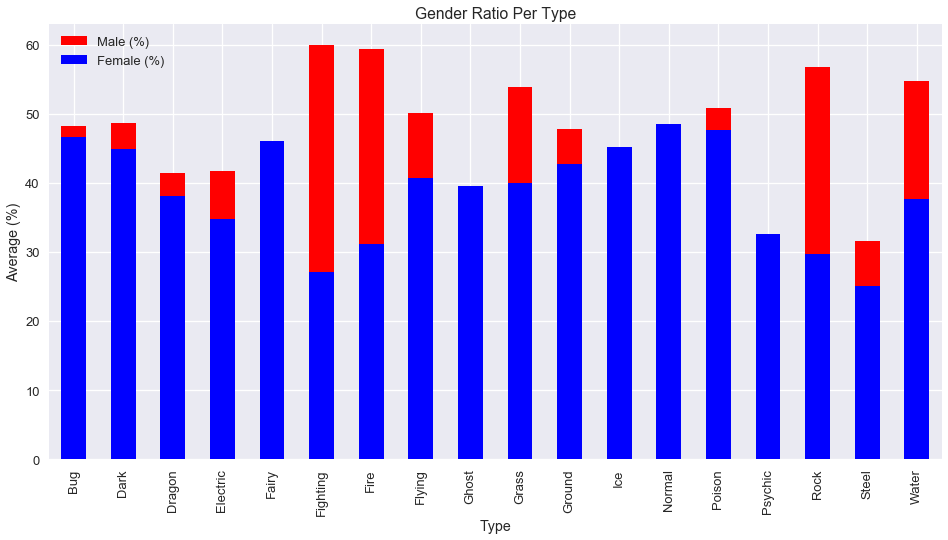

In [140]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))

avg_f = df3.groupby('Type')['Female (%)'].mean()
avg_m = df3.groupby('Type')['Male (%)'].mean()

avg_m.plot(kind='bar',color='red', stacked=True)
avg_f.plot(kind='bar',color='blue', stacked=True)

# adjust labels and plot
plt.ylabel('Average (%)')
plt.xlabel('Type')
plt.title('Gender Ratio Per Type')
plt.legend()
plt.show()

This graph plots the female ratio on top of the male ratio of Pokemon for each type. The bars that are all blue show that type has a higher female ratio of Pokemon, such as Fairy-type and Normal-type. As we can see, only 5 out of 18 types have a higher female than male ratio, so we can conclude that the majority of Pokemon types have a greater chance of being a male Pokemon. There are types where the average ratio for male and female are very close, such as Bug-type and Poison-type.

## 3. Machine Learning

We want to not only find patterns in our data, but also to be able to make predictions. This is the essence of machine learning. 

Lets do some K-Folding and cross validation.

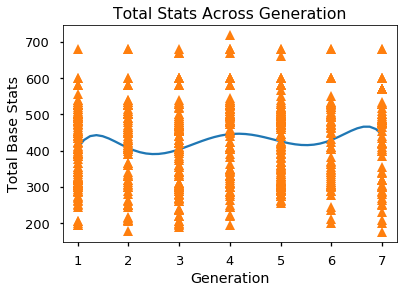

In [79]:
# let's do a 5-degree polynomial fit of total base stats across generation 
example_fit = np.polyfit(df['Generation'], df['Total'], 6)
example_poly = np.poly1d(example_fit)

predicted_x = np.linspace(1,7)
predicted_y = example_poly(predicted_x)

plt.plot(predicted_x, predicted_y)
plt.plot(df['Generation'], df['Total'], '^')
plt.title('Total Stats Across Generation')
plt.ylabel('Total Base Stats')
plt.xlabel('Generation')
plt.show()

In [14]:
X = df.as_matrix(["Total", "HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", "Height (m)", "Weight (kg)", "Catch Rate"])
y = df.as_matrix(["Type1"])
kf = KFold(n_splits=10, shuffle=True)

In [15]:
k = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = sklearn.neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(X_train, y_train.ravel())
    k = k + 1
    Z = clf.predict(X_test)
    y_test = np.ravel(y_test)
    print(sklearn.metrics.zero_one_loss(y_test,Z))


0.79012345679
0.802469135802
0.7875
0.8
0.7625
0.85
0.8375
0.7625
0.8625
0.7875


In [16]:
k = 9
total_loss = 0
knn_clf = sklearn.neighbors.KNeighborsClassifier(k, weights='uniform')
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_clf = sklearn.neighbors.KNeighborsClassifier(k, weights='uniform')
    knn_clf.fit(X_train, y_train.ravel())
    Z = clf.predict(X_test)
    y_test = np.ravel(y_test)
    total_loss = total_loss + sklearn.metrics.zero_one_loss(y_test, Z);
print(total_loss/10)

0.632083333333


<h2>Conclusion</h2>
We've analyzed 